In [1]:
import nengo
import nengo_spa as spa
import nengo_ocl
import matplotlib.pyplot as plt
import numpy as np

import string

D = 64
N = D * 20
period = .25
test_items = 5
T_learning = 10
T = T_learning + test_items*period

items = string.ascii_uppercase[:]
vocab = spa.Vocabulary(D)
vocab.populate(';'.join(list(items)+['CONV']))

def cycle_array(x1, x2, T_learning, period, add_to_output="", dt=0.001):
    """Cycles through the elements"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        x = x1
        if T_learning and t>T_learning:
            x = x2
        i = int(round((t - dt) / dt))  # t starts at dt
        return add_to_output + x[int(i / i_every) % len(x)]
        return x[int(i / i_every) % len(x)]+add_to_output

    return f



/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.10)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=18, similarity=0.11)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=20, similarity=0.12)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWar

In [2]:
with spa.Network() as model:
    
    inp = spa.Transcode(cycle_array(items[:-test_items], items[-test_items:], T_learning, period), output_vocab=vocab)
    x = nengo.Ensemble(N,D)
    nengo.Connection(inp.output, x)

    y = nengo.Ensemble(N,D)
    conn = nengo.Connection(x, y, function=lambda x: [0]*D, learning_rule_type=nengo.PES(learning_rate=1e-3))
    error = nengo.Node(lambda t,x: x if t<T_learning else 0*x, size_in=D, size_out=D)
    nengo.Connection(error, conn.learning_rule, synapse=None)
    nengo.Connection(y, error, synapse=None)


    y_decode = spa.Transcode(input_vocab=vocab, output_vocab=vocab)
    nengo.Connection(y, y_decode.input)    
    

    truth = spa.Transcode(cycle_array(items[:-test_items], items[-test_items:], T_learning, period, add_to_output='~'), output_vocab=vocab)
    nengo.Connection(truth.output, error, transform=-1, synapse=None)
    
    
    
    p_x = nengo.Probe(x, synapse=.05)
    p_y = nengo.Probe(y, synapse=.05)
    

In [3]:
with nengo_ocl.Simulator(model) as sim:
    sim.run(T)

No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

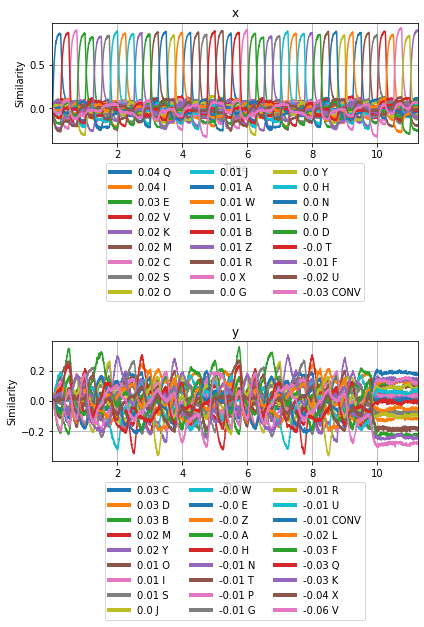

In [5]:

def plot_similarities(t_range, data, vocab, keys=False, autoscale=True, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1):

    if not keys:
        keys = list(vocab.keys())

    if subplot_nrows * subplot_ncols > 0:
        plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

    if permutation is None:
        permutation = range(vocab.dimensions)
    vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
    mean_activation = spa.similarity(data, vectors).mean(axis=0)
    sort_idx = np.argsort(mean_activation)[::-1]    

    ymin, ymax = -1.2, 1.2
    plt.ylim(ymin, ymax)
    plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    plt.plot(t_range, spa.similarity(data, vectors[sort_idx]))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Similarity")
    plt.xlim(left=t_range[0], right=t_range[-1])
    leg = plt.legend([str(round(mean_activation[sort_idx][i],2))+' '+k for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center',
               bbox_to_anchor=(0.5, -0.13), ncol=3)

    # set the linewidth of each legend object
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)

    if subplot_nrows * subplot_ncols == 0:
        plt.show()

    return subplot_i + 1



subplot_nrows=2
subplot_ncols=1
plt.figure(figsize=(6*subplot_ncols,4.5*subplot_nrows))

start = 0
end = T
skip = 5
trange = sim.trange()
selected_idx = np.where(np.logical_and(trange > start, trange < end))
trange = trange[selected_idx][::skip]


subplot_i=plot_similarities(trange, sim.data[p_x][selected_idx][::skip], vocab, title='x', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
#subplot_i=plot_similarities(trange, sim.data[p_y][selected_idx][::skip], vocab, keys=[item+'*CONV' for item in ['A','B','C','D', 'E', 'F']], title='y', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
subplot_i=plot_similarities(trange, sim.data[p_y][selected_idx][::skip], vocab, title='y', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)


plt.tight_layout()

plt.show()
